In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Load Windows logs ---
windows_logs = pd.read_csv("logs/Apache_2k.log_structured.csv")
print("[INFO] Windows Logs Loaded:", windows_logs.shape)

# --- 2️⃣ Load Web Logs ---
web_logs = pd.read_csv("logs/web log.csv")
print("[INFO] Web Logs Loaded:", web_logs.shape)


# Check column names
print("\nWindows columns:", windows_logs.columns.tolist())
print("Web columns:", web_logs.columns.tolist())



[INFO] Windows Logs Loaded: (2000, 6)
[INFO] Web Logs Loaded: (61065, 17)

Windows columns: ['LineId', 'Time', 'Level', 'Content', 'EventId', 'EventTemplate']
Web columns: ['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL']


In [3]:
# --- 🧹 Data Cleaning Section ---
import pandas as pd

# ✅ Clean Windows Logs
windows_logs.dropna(inplace=True)
windows_logs['Level'] = windows_logs['Level'].astype(str).str.strip().str.lower()

# ✅ Clean Web Logs
# Fix: use 'url' (lowercase) instead of 'URL'
web_logs.columns = [col.strip().lower().replace(' ', '_') for col in web_logs.columns]
if 'url' in web_logs.columns:
    web_logs.dropna(subset=['url'], inplace=True)


print("[INFO] Cleaning done ✅")
print("Windows Logs:", windows_logs.shape)
print("Web Logs:", web_logs.shape)

# ✅ Ensure string type
for df, cols in [
    (windows_logs, ['Level']),
    (web_logs, ['classification'])
]:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(str)


[INFO] Cleaning done ✅
Windows Logs: (2000, 6)
Web Logs: (61065, 17)


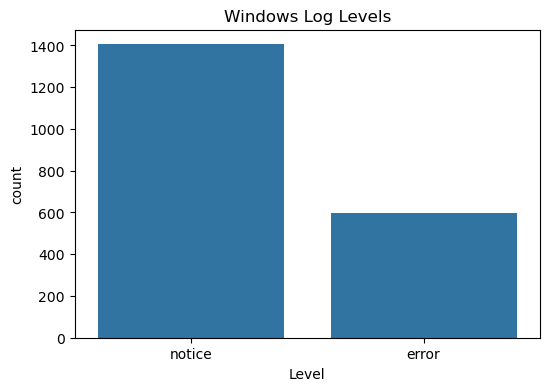

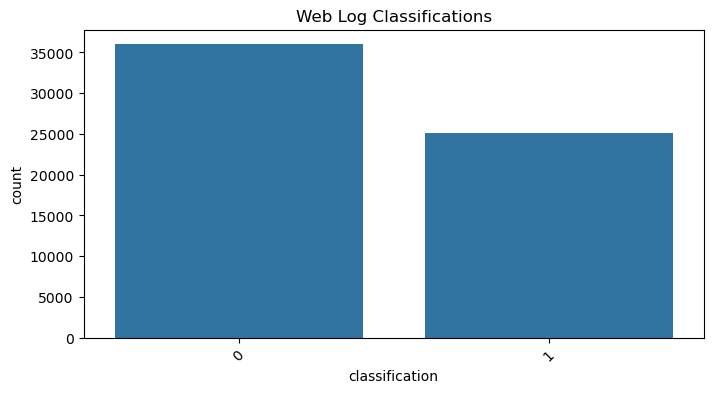

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Windows Log Severity Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(data=windows_logs, x='Level')
plt.title("Windows Log Levels")
plt.show()

# --- Web Log Classification Distribution ---
plt.figure(figsize=(8,4))
sns.countplot(data=web_logs, x='classification')
plt.title("Web Log Classifications")
plt.xticks(rotation=45)
plt.show()



In [5]:
print("\n[Windows Levels]", windows_logs['Level'].unique()[:10])
print("\n[Web Classifications]", web_logs['classification'].unique()[:10])

# --- 🚨 Suspicious Pattern Detection (Fixed for Your Dataset) ---

# Detect Windows errors or failures
suspicious_windows = windows_logs[
    windows_logs['Level'].str.lower().isin(['fatal', 'error', 'critical'])
]

# Detect malicious or abnormal web requests
# 1 = attack, 0 = normal
suspicious_web = web_logs[
    web_logs['classification'].astype(str).str.strip() == '1'
]


print("\n[ALERT] Suspicious Windows Logs:", suspicious_windows.shape)
print("[ALERT] Suspicious Web Logs:", suspicious_web.shape)

# --- ✅ Save Suspicious Logs for further analysis ---
import os
os.makedirs("alerts", exist_ok=True)

suspicious_windows.to_csv("alerts/suspicious_windows.csv", index=False)
suspicious_web.to_csv("alerts/suspicious_web.csv", index=False)

print("\n[INFO] Suspicious logs saved in 'alerts/' folder ✅")



[Windows Levels] ['notice' 'error']

[Web Classifications] ['0' '1']

[ALERT] Suspicious Windows Logs: (595, 6)
[ALERT] Suspicious Web Logs: (25065, 17)

[INFO] Suspicious logs saved in 'alerts/' folder ✅


In [6]:
total_alerts = (
    len(suspicious_windows) +
    len(suspicious_web) 
)

print("\n🧾 Alert Summary Report")
print("-" * 50)
print(f"Windows Alerts: {len(suspicious_windows)}")
print(f"Web Alerts: {len(suspicious_web)}")
print(f"TOTAL Alerts Generated: {total_alerts}")
print("-" * 50)

# 🪟 Show details for Windows alerts
if len(suspicious_windows) > 0:
    print("\n⚠️ Suspicious Windows Logs:")
    print(suspicious_windows[['LineId', 'Time', 'Level']].head(10))
else:
    print("\n✅ No suspicious Windows logs detected.")

if len(suspicious_web) > 0:
    print("\n⚠️ Suspicious Web Logs:")
    # Showing most relevant columns for analysis
    print(suspicious_web[['unnamed:_0', 'method', 'host', 'classification']].head(10))
else:
    print("\n✅ No suspicious Web logs detected.")





🧾 Alert Summary Report
--------------------------------------------------
Windows Alerts: 595
Web Alerts: 25065
TOTAL Alerts Generated: 25660
--------------------------------------------------

⚠️ Suspicious Windows Logs:
    LineId                      Time  Level
1        2  Sun Dec 04 04:47:44 2005  error
8        9  Sun Dec 04 04:51:18 2005  error
9       10  Sun Dec 04 04:51:18 2005  error
10      11  Sun Dec 04 04:51:18 2005  error
16      17  Sun Dec 04 04:51:55 2005  error
24      25  Sun Dec 04 04:52:15 2005  error
25      26  Sun Dec 04 04:52:15 2005  error
26      27  Sun Dec 04 04:52:15 2005  error
32      33  Sun Dec 04 04:52:52 2005  error
33      34  Sun Dec 04 04:52:52 2005  error

⚠️ Suspicious Web Logs:
      unnamed:_0 method            host classification
36000  Anomalous    GET  localhost:8080              1
36001  Anomalous   POST  localhost:8080              1
36002  Anomalous    GET  localhost:8080              1
36003  Anomalous   POST  localhost:8080         

In [11]:
import re
import pandas as pd

# 🧠 Attack classification function
def classify_attack(entry):
    entry_lower = str(entry).lower()

    if re.search(r"(\bselect\b|\bdrop\b|\bunion\b|\binsert\b|\bdelete\b|\bupdate\b)", entry_lower):
        return "SQL Injection Attempt"
    elif re.search(r"(<script>|%3cscript|alert\(|onerror=|onload=)", entry_lower):
        return "Cross-Site Scripting (XSS) Attempt"
    elif re.search(r"(login|failed|unauthorized|invalid password|attempt)", entry_lower):
        return "Brute-force / Unauthorized Login Attempt"
    elif re.search(r"(\.\./|\.\.\\|/etc/passwd|/windows/system32)", entry_lower):
        return "Directory Traversal Attempt"
    elif re.search(r"(include=|file=|path=|load=)", entry_lower):
        return "File Inclusion Attack"
    elif re.search(r"(cmd=|exec=|system\(|shell)", entry_lower):
        return "Command Injection Attempt"
    else:
        return "General Suspicious Activity"


# 🧾 Alert Summary
total_alerts = (
    len(suspicious_windows) +
    len(suspicious_web) 
)

print("\n🧾 Alert Summary Report")
print("-" * 50)
print(f"Windows Alerts: {len(suspicious_windows)}")
print(f"Web Alerts: {len(suspicious_web)}")
print(f"TOTAL Alerts Generated: {total_alerts}")
print("-" * 50)

print("\n📋 Windows Log Columns:", suspicious_windows.columns.tolist())

# 🪟 Suspicious Windows Logs
if len(suspicious_windows) > 0:
    print("\n⚠️ Suspicious Windows Logs:")
    suspicious_windows = suspicious_windows.copy()
    suspicious_windows["Attack_Type"] = suspicious_windows["Level"].apply(classify_attack)
    print(suspicious_windows[['LineId', 'Time', 'Level', 'Attack_Type']].head(10).to_string(index=False))
else:
    print("\n✅ No suspicious Windows logs detected.")


# 🌐 Suspicious Web Logs
if len(suspicious_web) > 0:
    print("\n⚠️ Suspicious Web Logs:")
    suspicious_web = suspicious_web.copy()
    # pick the most descriptive column for pattern matching
    if "url" in suspicious_web.columns:
        suspicious_web["Attack_Type"] = suspicious_web["url"].apply(classify_attack)
    elif "host" in suspicious_web.columns:
        suspicious_web["Attack_Type"] = suspicious_web["host"].apply(classify_attack)
    else:
        suspicious_web["Attack_Type"] = suspicious_web["method"].apply(classify_attack)
    print(suspicious_web[['unnamed:_0', 'method', 'host', 'classification', 'Attack_Type']].head(10).to_string(index=False))
else:
    print("\n✅ No suspicious Web logs detected.")


print("\n🟢 Report generated successfully!\n")



🧾 Alert Summary Report
--------------------------------------------------
Windows Alerts: 595
Web Alerts: 25065
TOTAL Alerts Generated: 25660
--------------------------------------------------

📋 Windows Log Columns: ['LineId', 'Time', 'Level', 'Content', 'EventId', 'EventTemplate', 'Attack_Type']

⚠️ Suspicious Windows Logs:
 LineId                     Time Level                 Attack_Type
      2 Sun Dec 04 04:47:44 2005 error General Suspicious Activity
      9 Sun Dec 04 04:51:18 2005 error General Suspicious Activity
     10 Sun Dec 04 04:51:18 2005 error General Suspicious Activity
     11 Sun Dec 04 04:51:18 2005 error General Suspicious Activity
     17 Sun Dec 04 04:51:55 2005 error General Suspicious Activity
     25 Sun Dec 04 04:52:15 2005 error General Suspicious Activity
     26 Sun Dec 04 04:52:15 2005 error General Suspicious Activity
     27 Sun Dec 04 04:52:15 2005 error General Suspicious Activity
     33 Sun Dec 04 04:52:52 2005 error General Suspicious Activity
 